In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit


from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#installing data from roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Z62IjzbCnbHCgFap668O")
project = rf.workspace("dataset-lq4an").project("recycling-plastic")
version = project.version(5)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to recycling-plastic-5 in folder:: 100%|██████████| 1782/1782 [00:00<00:00, 9828.02it/s]


In [ ]:
#concate all images
# Path ke masing-masing dataset
train_data_url = '/content/recycling-plastic-5/train'
test_data_url = '/content/recycling-plastic-5/test'
valid_data_url = '/content/recycling-plastic-5/valid'

# Path untuk menyimpan hasil penggabungan
output_dir = '/content/recycling-plastic-5/combined'
os.makedirs(output_dir, exist_ok=True)

# List kelas (sesuai nama folder)
classes = ['1', '2', '3', '4', '5', '6', '7']

# Fungsi untuk menggabungkan file berdasarkan kelas
def combine_images(source_dirs, target_dir, classes):
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        os.makedirs(class_dir, exist_ok=True)  # Buat folder untuk setiap kelas

        # Gabungkan gambar dari setiap sumber folder
        for source_dir in source_dirs:
            source_class_dir = os.path.join(source_dir, cls)
            if os.path.exists(source_class_dir):
                for img_file in os.listdir(source_class_dir):
                    src_path = os.path.join(source_class_dir, img_file)
                    dst_path = os.path.join(class_dir, img_file)

                    # Salin file ke folder tujuan
                    shutil.copy(src_path, dst_path)

# Gabungkan gambar dari train, test, dan valid
combine_images([train_data_url, test_data_url, valid_data_url], output_dir, classes)

## Load Image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_path = '/content/recycling-plastic-5/combined'
dataset = ImageFolder(data_path)
class_names = dataset.classes

## Visualize Image

1


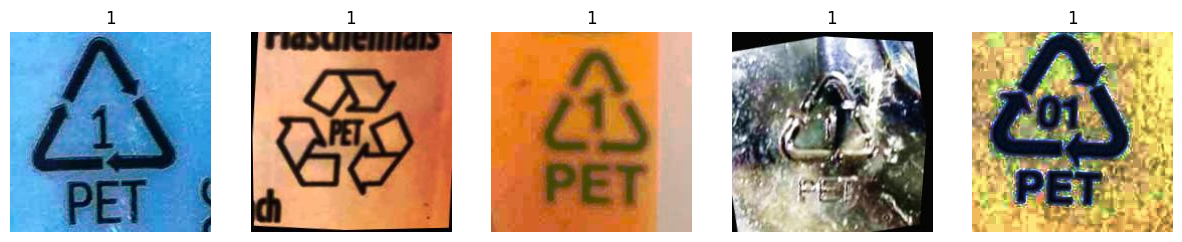

2


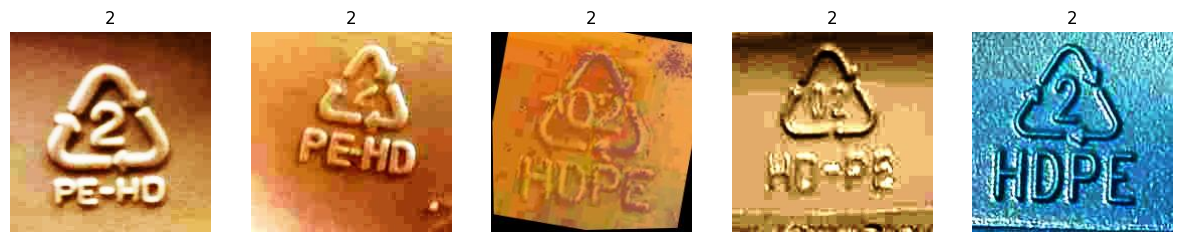

3


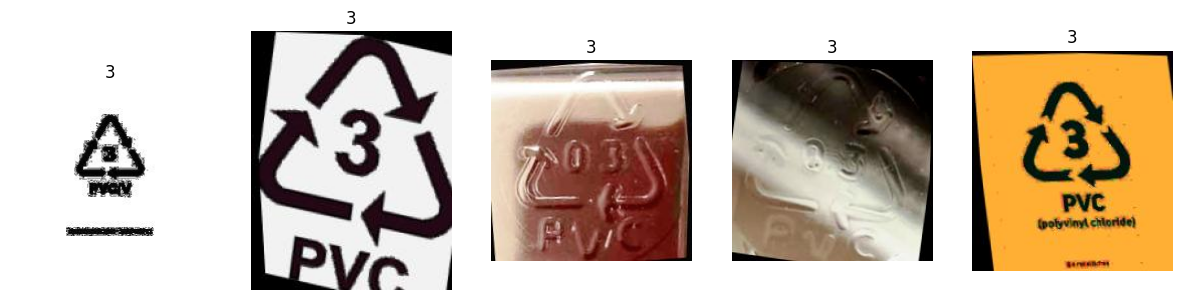

4


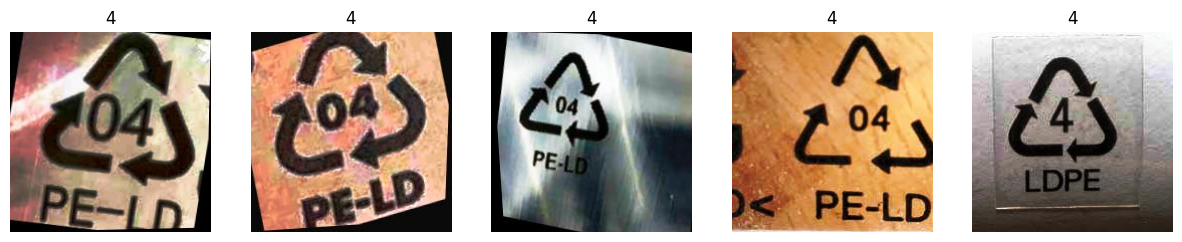

5


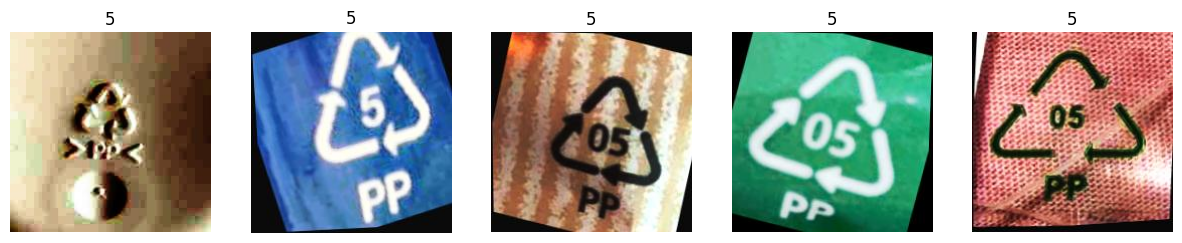

6


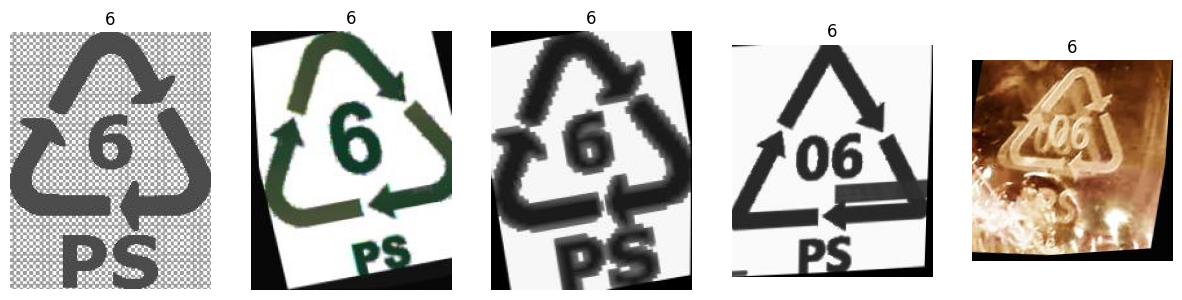

7


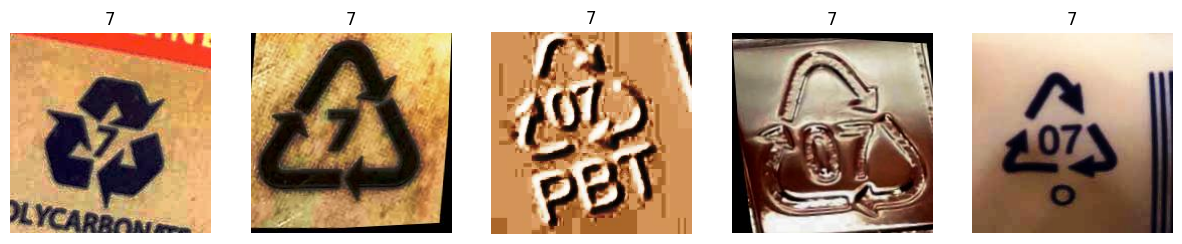

In [ ]:
for class_name in class_names :
    class_dir = os.path.join(data_path, class_name)
    imgs = os.listdir(class_dir)
    print(class_name)

    fig, axs = plt.subplots(1,5, figsize=(15,5))

    for i,img in enumerate(imgs[:5]):
        img_path = os.path.join(class_dir, img)
        img = Image.open(img_path)

        # Plot setiap gambar
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(class_name)

    plt.show()

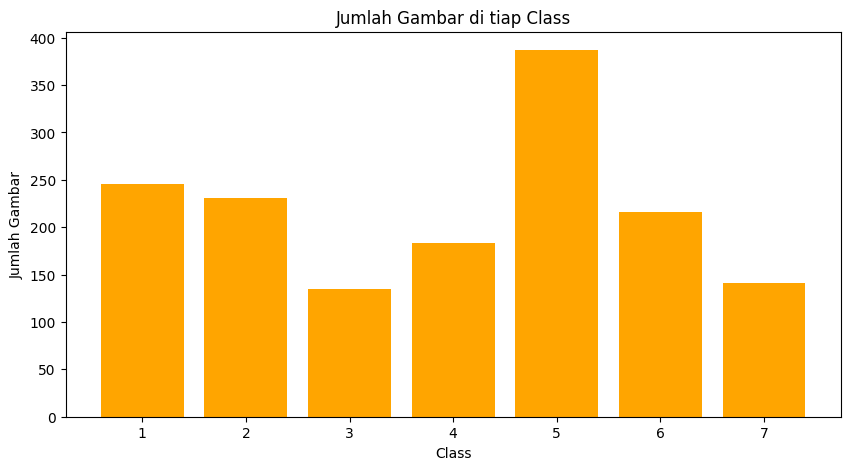

In [ ]:
img_count = {
    class_name : len(os.listdir(os.path.join(train_data_url, class_name)))
    for class_name in class_names
}

plt.figure(figsize=(10, 5))
plt.bar(img_count.keys(), img_count.values(), color='orange')
plt.xlabel('Class')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar di tiap Class')
plt.show()

## Data Pre-Processing
- Data Augmentation
- Splitting Data
- Plotting Augmented Data

In [ ]:
# Inisialisasi augmentasi/transformasi data gambar
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=1),
    transforms.ColorJitter(contrast=0.2, brightness= 0.2, saturation=0.2, hue=0.2),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std= [0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std= [0.225])
])

In [ ]:
file_paths = [sample[0] for sample in dataset.samples]
labels = [dataset.targets[i] for i in range(len(dataset))]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(file_paths, labels))

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

In [ ]:
print(f'total dataset = {len(dataset.samples)}')
print(f'total train dataset = {len(train_dataset)}')
print(f'total test dataset = {len(test_dataset)}')

total dataset = 1756
total train dataset = 1404
total test dataset = 352


In [ ]:
train_dataset.dataset = datasets.ImageFolder(data_path, transform=train_transforms)
test_dataset.dataset = datasets.ImageFolder(data_path, transform=test_transforms)

In [ ]:
# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Tampilkan beberapa batch data pelatihan untuk verifikasi
images, labels = next(iter(train_loader))
print(f"Shape of images: {images.shape}")
print(f"Labels: {labels}")

Shape of images: torch.Size([32, 1, 224, 224])
Labels: tensor([0, 4, 4, 4, 1, 3, 2, 5, 6, 4, 4, 2, 1, 1, 4, 6, 3, 0, 6, 5, 6, 4, 1, 1,
        5, 5, 2, 0, 0, 4, 3, 0])


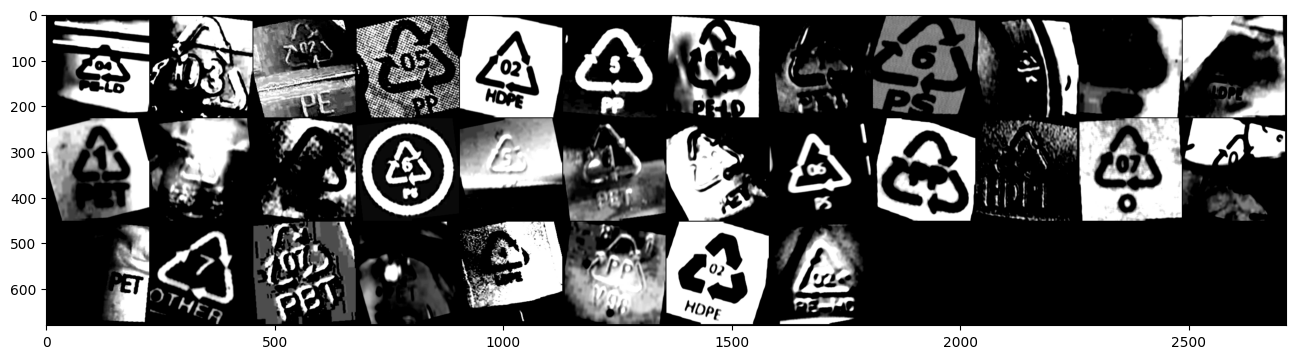

In [ ]:
for batch in train_loader:
    plt.figure(figsize=(16,8))
    image,_ = batch
    grid = torchvision.utils.make_grid(image, nrow=12).permute(1,2,0)
    plt.imshow(grid)
    break;

## Modeling

### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(in_features=512*7*7, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=7)

        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # 3x112x112
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # 3x56x56
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # 3x28x28
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x)))) # 3x14x14
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn5(self.conv5(x)))) # 3x7x7
        x = self.dropout(x)
        x = F.relu(self.bn6(self.conv6(x))) # 3x7x7
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().to(device)
model.eval()

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
#ctotal params model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 10927751


In [ ]:
# Fungsi loss
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
input_tensor = torch.randn(32, 1, 224, 224)  # Batch size 16, RGB, ukuran 64x64
output = model(input_tensor.to(device))
print(output.size())

torch.Size([32, 7])


### Resnet34 Pretrained

In [ ]:
#resnet34 model
resnet34_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

resnet34_model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
resnet34_model.fc = nn.Linear(in_features=512, out_features=7, bias=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
resnet34_model = resnet34_model.to(device)
resnet34_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = optim.Adam(resnet34_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
input_tensor = torch.randn(32, 1, 224, 224)  # Batch size 16, RGB, ukuran 64x64
output = resnet34_model(input_tensor.to(device))
print(output.size())

torch.Size([32, 7])


In [ ]:
#total parameters
sum(p.numel() for p in resnet34_model.parameters())

21279431

### Training Model

In [ ]:
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def evaluate(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
    avg_loss = running_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy, all_labels, all_preds


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate training accuracy
        train_accuracy = accuracy(outputs, labels)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluate on test set
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, valid_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Return metrics for plotting
    return train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds = train(
    model, train_loader, test_loader, optimizer, criterion
)

100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [1/100]
Train Loss: 2.8137, Train Accuracy: 0.1786
Test Loss: 1.8805, Test Accuracy: 0.2585


100%|██████████| 44/44 [00:13<00:00,  3.21it/s]


Epoch [2/100]
Train Loss: 1.8744, Train Accuracy: 0.1429
Test Loss: 1.8663, Test Accuracy: 0.2500


100%|██████████| 44/44 [00:13<00:00,  3.17it/s]


Epoch [3/100]
Train Loss: 1.8606, Train Accuracy: 0.1429
Test Loss: 1.8329, Test Accuracy: 0.2983


100%|██████████| 44/44 [00:13<00:00,  3.18it/s]


Epoch [4/100]
Train Loss: 1.7895, Train Accuracy: 0.2857
Test Loss: 1.7546, Test Accuracy: 0.2983


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [5/100]
Train Loss: 1.7652, Train Accuracy: 0.1786
Test Loss: 1.7579, Test Accuracy: 0.3153


100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Epoch [6/100]
Train Loss: 1.7443, Train Accuracy: 0.1071
Test Loss: 1.7243, Test Accuracy: 0.3011


100%|██████████| 44/44 [00:14<00:00,  3.05it/s]


Epoch [7/100]
Train Loss: 1.7531, Train Accuracy: 0.1786
Test Loss: 1.7188, Test Accuracy: 0.2955


100%|██████████| 44/44 [00:13<00:00,  3.20it/s]


Epoch [8/100]
Train Loss: 1.7102, Train Accuracy: 0.5357
Test Loss: 1.7631, Test Accuracy: 0.2756


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [9/100]
Train Loss: 1.6878, Train Accuracy: 0.5357
Test Loss: 1.6331, Test Accuracy: 0.3097


100%|██████████| 44/44 [00:14<00:00,  3.14it/s]


Epoch [10/100]
Train Loss: 1.6770, Train Accuracy: 0.2857
Test Loss: 1.6954, Test Accuracy: 0.2756


100%|██████████| 44/44 [00:14<00:00,  3.00it/s]


Epoch [11/100]
Train Loss: 1.6368, Train Accuracy: 0.2857
Test Loss: 1.6012, Test Accuracy: 0.3494


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [12/100]
Train Loss: 1.6039, Train Accuracy: 0.3214
Test Loss: 1.6406, Test Accuracy: 0.2926


100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


Epoch [13/100]
Train Loss: 1.6004, Train Accuracy: 0.3214
Test Loss: 1.5516, Test Accuracy: 0.3665


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [14/100]
Train Loss: 1.5758, Train Accuracy: 0.3571
Test Loss: 1.6351, Test Accuracy: 0.3636


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [15/100]
Train Loss: 1.5251, Train Accuracy: 0.3571
Test Loss: 1.5403, Test Accuracy: 0.3835


100%|██████████| 44/44 [00:13<00:00,  3.15it/s]


Epoch [16/100]
Train Loss: 1.4995, Train Accuracy: 0.2857
Test Loss: 1.4912, Test Accuracy: 0.4290


100%|██████████| 44/44 [00:13<00:00,  3.15it/s]


Epoch [17/100]
Train Loss: 1.4647, Train Accuracy: 0.3571
Test Loss: 1.4528, Test Accuracy: 0.4545


100%|██████████| 44/44 [00:13<00:00,  3.18it/s]


Epoch [18/100]
Train Loss: 1.4724, Train Accuracy: 0.3929
Test Loss: 1.4017, Test Accuracy: 0.4688


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [19/100]
Train Loss: 1.4323, Train Accuracy: 0.2500
Test Loss: 1.3739, Test Accuracy: 0.4773


100%|██████████| 44/44 [00:14<00:00,  3.08it/s]


Epoch [20/100]
Train Loss: 1.3690, Train Accuracy: 0.6071
Test Loss: 1.4101, Test Accuracy: 0.4517


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [21/100]
Train Loss: 1.3431, Train Accuracy: 0.3929
Test Loss: 1.3249, Test Accuracy: 0.4886


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [22/100]
Train Loss: 1.2917, Train Accuracy: 0.4286
Test Loss: 1.1785, Test Accuracy: 0.5824


100%|██████████| 44/44 [00:14<00:00,  3.05it/s]


Epoch [23/100]
Train Loss: 1.2428, Train Accuracy: 0.4643
Test Loss: 1.2181, Test Accuracy: 0.5568


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [24/100]
Train Loss: 1.1896, Train Accuracy: 0.6786
Test Loss: 1.1385, Test Accuracy: 0.5909


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [25/100]
Train Loss: 1.1905, Train Accuracy: 0.6786
Test Loss: 1.2108, Test Accuracy: 0.5625


100%|██████████| 44/44 [00:13<00:00,  3.15it/s]


Epoch [26/100]
Train Loss: 1.1659, Train Accuracy: 0.5357
Test Loss: 1.0802, Test Accuracy: 0.5994


100%|██████████| 44/44 [00:13<00:00,  3.15it/s]


Epoch [27/100]
Train Loss: 1.1459, Train Accuracy: 0.5714
Test Loss: 1.0387, Test Accuracy: 0.6307


100%|██████████| 44/44 [00:14<00:00,  2.93it/s]


Epoch [28/100]
Train Loss: 1.0919, Train Accuracy: 0.6786
Test Loss: 1.1098, Test Accuracy: 0.6335


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [29/100]
Train Loss: 1.0512, Train Accuracy: 0.7857
Test Loss: 1.0447, Test Accuracy: 0.6364


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [30/100]
Train Loss: 1.0002, Train Accuracy: 0.4643
Test Loss: 0.9840, Test Accuracy: 0.6335


100%|██████████| 44/44 [00:13<00:00,  3.16it/s]


Epoch [31/100]
Train Loss: 1.0496, Train Accuracy: 0.5000
Test Loss: 0.9876, Test Accuracy: 0.6705


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [32/100]
Train Loss: 0.9697, Train Accuracy: 0.6786
Test Loss: 0.9120, Test Accuracy: 0.7159


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [33/100]
Train Loss: 0.9695, Train Accuracy: 0.4643
Test Loss: 0.9597, Test Accuracy: 0.6733


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [34/100]
Train Loss: 0.9027, Train Accuracy: 0.4286
Test Loss: 0.8038, Test Accuracy: 0.7216


100%|██████████| 44/44 [00:14<00:00,  3.08it/s]


Epoch [35/100]
Train Loss: 0.8692, Train Accuracy: 0.6071
Test Loss: 0.7839, Test Accuracy: 0.7500


100%|██████████| 44/44 [00:13<00:00,  3.17it/s]


Epoch [36/100]
Train Loss: 0.8900, Train Accuracy: 0.4643
Test Loss: 0.8338, Test Accuracy: 0.7273


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [37/100]
Train Loss: 0.8469, Train Accuracy: 0.6786
Test Loss: 0.6876, Test Accuracy: 0.8011


100%|██████████| 44/44 [00:14<00:00,  3.06it/s]


Epoch [38/100]
Train Loss: 0.8082, Train Accuracy: 0.5000
Test Loss: 0.7057, Test Accuracy: 0.7642


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [39/100]
Train Loss: 0.8417, Train Accuracy: 0.7500
Test Loss: 0.7484, Test Accuracy: 0.7415


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [40/100]
Train Loss: 0.7807, Train Accuracy: 0.5714
Test Loss: 0.6549, Test Accuracy: 0.7869


100%|██████████| 44/44 [00:14<00:00,  3.10it/s]


Epoch [41/100]
Train Loss: 0.7225, Train Accuracy: 0.7143
Test Loss: 0.6777, Test Accuracy: 0.7670


100%|██████████| 44/44 [00:14<00:00,  3.14it/s]


Epoch [42/100]
Train Loss: 0.7674, Train Accuracy: 0.5714
Test Loss: 0.6907, Test Accuracy: 0.7528


100%|██████████| 44/44 [00:13<00:00,  3.15it/s]


Epoch [43/100]
Train Loss: 0.7855, Train Accuracy: 0.5357
Test Loss: 0.7249, Test Accuracy: 0.7443


100%|██████████| 44/44 [00:14<00:00,  2.94it/s]


Epoch [44/100]
Train Loss: 0.7249, Train Accuracy: 0.7143
Test Loss: 0.7369, Test Accuracy: 0.7727


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [45/100]
Train Loss: 0.7225, Train Accuracy: 0.7857
Test Loss: 0.6027, Test Accuracy: 0.8011


100%|██████████| 44/44 [00:14<00:00,  3.14it/s]


Epoch [46/100]
Train Loss: 0.6971, Train Accuracy: 0.7143
Test Loss: 0.5697, Test Accuracy: 0.8239


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [47/100]
Train Loss: 0.6145, Train Accuracy: 0.7143
Test Loss: 0.4965, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [48/100]
Train Loss: 0.6426, Train Accuracy: 0.7857
Test Loss: 0.5758, Test Accuracy: 0.8097


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [49/100]
Train Loss: 0.6592, Train Accuracy: 0.7143
Test Loss: 0.6118, Test Accuracy: 0.8182


100%|██████████| 44/44 [00:14<00:00,  3.05it/s]


Epoch [50/100]
Train Loss: 0.6056, Train Accuracy: 0.8214
Test Loss: 0.5568, Test Accuracy: 0.8466


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [51/100]
Train Loss: 0.6164, Train Accuracy: 0.6786
Test Loss: 0.5218, Test Accuracy: 0.8494


100%|██████████| 44/44 [00:13<00:00,  3.15it/s]


Epoch [52/100]
Train Loss: 0.6731, Train Accuracy: 0.6429
Test Loss: 0.6182, Test Accuracy: 0.8097


100%|██████████| 44/44 [00:14<00:00,  3.08it/s]


Epoch [53/100]
Train Loss: 0.6232, Train Accuracy: 0.7857
Test Loss: 0.5466, Test Accuracy: 0.8608


100%|██████████| 44/44 [00:14<00:00,  3.07it/s]


Epoch [54/100]
Train Loss: 0.5864, Train Accuracy: 0.8571
Test Loss: 0.4837, Test Accuracy: 0.8636


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [55/100]
Train Loss: 0.5922, Train Accuracy: 0.7857
Test Loss: 0.4666, Test Accuracy: 0.8750


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [56/100]
Train Loss: 0.5980, Train Accuracy: 0.8214
Test Loss: 0.5070, Test Accuracy: 0.8636


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [57/100]
Train Loss: 0.5469, Train Accuracy: 0.7500
Test Loss: 0.4106, Test Accuracy: 0.8750


100%|██████████| 44/44 [00:14<00:00,  3.08it/s]


Epoch [58/100]
Train Loss: 0.6160, Train Accuracy: 0.7500
Test Loss: 0.4958, Test Accuracy: 0.8438


100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Epoch [59/100]
Train Loss: 0.5440, Train Accuracy: 0.6786
Test Loss: 0.4855, Test Accuracy: 0.8494


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [60/100]
Train Loss: 0.5685, Train Accuracy: 0.7500
Test Loss: 0.4456, Test Accuracy: 0.8580


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [61/100]
Train Loss: 0.5710, Train Accuracy: 0.8214
Test Loss: 0.4793, Test Accuracy: 0.8778


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [62/100]
Train Loss: 0.5397, Train Accuracy: 0.6429
Test Loss: 0.4556, Test Accuracy: 0.8636


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [63/100]
Train Loss: 0.5266, Train Accuracy: 0.7857
Test Loss: 0.4319, Test Accuracy: 0.8977


100%|██████████| 44/44 [00:14<00:00,  3.08it/s]


Epoch [64/100]
Train Loss: 0.5162, Train Accuracy: 0.8214
Test Loss: 0.5387, Test Accuracy: 0.7983


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [65/100]
Train Loss: 0.5472, Train Accuracy: 0.7143
Test Loss: 0.5029, Test Accuracy: 0.8494


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [66/100]
Train Loss: 0.5726, Train Accuracy: 0.6786
Test Loss: 0.4411, Test Accuracy: 0.8977


100%|██████████| 44/44 [00:14<00:00,  3.08it/s]


Epoch [67/100]
Train Loss: 0.4979, Train Accuracy: 0.8571
Test Loss: 0.4462, Test Accuracy: 0.8864


100%|██████████| 44/44 [00:13<00:00,  3.16it/s]


Epoch [68/100]
Train Loss: 0.5053, Train Accuracy: 0.6786
Test Loss: 0.5294, Test Accuracy: 0.8665


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [69/100]
Train Loss: 0.5305, Train Accuracy: 0.8571
Test Loss: 0.4956, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.06it/s]


Epoch [70/100]
Train Loss: 0.5311, Train Accuracy: 0.7500
Test Loss: 0.4502, Test Accuracy: 0.8864


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [71/100]
Train Loss: 0.4875, Train Accuracy: 0.7500
Test Loss: 0.5012, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [72/100]
Train Loss: 0.5030, Train Accuracy: 0.8571
Test Loss: 0.4846, Test Accuracy: 0.8835


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [73/100]
Train Loss: 0.5234, Train Accuracy: 0.6429
Test Loss: 0.4609, Test Accuracy: 0.8920


100%|██████████| 44/44 [00:14<00:00,  3.07it/s]


Epoch [74/100]
Train Loss: 0.5225, Train Accuracy: 0.8571
Test Loss: 0.4569, Test Accuracy: 0.8835


100%|██████████| 44/44 [00:15<00:00,  2.92it/s]


Epoch [75/100]
Train Loss: 0.4655, Train Accuracy: 0.7143
Test Loss: 0.4661, Test Accuracy: 0.8807


100%|██████████| 44/44 [00:13<00:00,  3.14it/s]


Epoch [76/100]
Train Loss: 0.4619, Train Accuracy: 0.7857
Test Loss: 0.4182, Test Accuracy: 0.8892


100%|██████████| 44/44 [00:14<00:00,  3.03it/s]


Epoch [77/100]
Train Loss: 0.4772, Train Accuracy: 0.7500
Test Loss: 0.5087, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [78/100]
Train Loss: 0.4973, Train Accuracy: 0.8214
Test Loss: 0.4996, Test Accuracy: 0.8551


100%|██████████| 44/44 [00:14<00:00,  3.07it/s]


Epoch [79/100]
Train Loss: 0.4986, Train Accuracy: 0.8571
Test Loss: 0.4955, Test Accuracy: 0.8835


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [80/100]
Train Loss: 0.4882, Train Accuracy: 0.6071
Test Loss: 0.5257, Test Accuracy: 0.8580


100%|██████████| 44/44 [00:14<00:00,  3.07it/s]


Epoch [81/100]
Train Loss: 0.4701, Train Accuracy: 0.6429
Test Loss: 0.4959, Test Accuracy: 0.8722


100%|██████████| 44/44 [00:14<00:00,  3.06it/s]


Epoch [82/100]
Train Loss: 0.5121, Train Accuracy: 0.7143
Test Loss: 0.5284, Test Accuracy: 0.8551


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [83/100]
Train Loss: 0.4495, Train Accuracy: 0.7500
Test Loss: 0.4549, Test Accuracy: 0.8864


100%|██████████| 44/44 [00:13<00:00,  3.14it/s]


Epoch [84/100]
Train Loss: 0.4865, Train Accuracy: 0.7857
Test Loss: 0.3956, Test Accuracy: 0.9006


100%|██████████| 44/44 [00:17<00:00,  2.51it/s]


Epoch [85/100]
Train Loss: 0.4841, Train Accuracy: 0.7143
Test Loss: 0.4523, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [86/100]
Train Loss: 0.4795, Train Accuracy: 0.8214
Test Loss: 0.4898, Test Accuracy: 0.8523


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [87/100]
Train Loss: 0.4425, Train Accuracy: 0.7500
Test Loss: 0.4216, Test Accuracy: 0.8864


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [88/100]
Train Loss: 0.4253, Train Accuracy: 0.8214
Test Loss: 0.6052, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.14it/s]


Epoch [89/100]
Train Loss: 0.4672, Train Accuracy: 0.7500
Test Loss: 0.5169, Test Accuracy: 0.8892


100%|██████████| 44/44 [00:14<00:00,  3.00it/s]


Epoch [90/100]
Train Loss: 0.4367, Train Accuracy: 0.7857
Test Loss: 0.4390, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [91/100]
Train Loss: 0.4409, Train Accuracy: 0.7500
Test Loss: 0.5137, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  2.97it/s]


Epoch [92/100]
Train Loss: 0.4594, Train Accuracy: 0.6429
Test Loss: 0.4744, Test Accuracy: 0.8693


100%|██████████| 44/44 [00:14<00:00,  3.07it/s]


Epoch [93/100]
Train Loss: 0.4843, Train Accuracy: 0.6786
Test Loss: 0.4346, Test Accuracy: 0.9034


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [94/100]
Train Loss: 0.4187, Train Accuracy: 0.8214
Test Loss: 0.4194, Test Accuracy: 0.8949


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [95/100]
Train Loss: 0.4238, Train Accuracy: 0.8214
Test Loss: 0.4430, Test Accuracy: 0.8920


100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Epoch [96/100]
Train Loss: 0.4215, Train Accuracy: 0.8214
Test Loss: 0.4584, Test Accuracy: 0.8835


100%|██████████| 44/44 [00:14<00:00,  3.13it/s]


Epoch [97/100]
Train Loss: 0.4197, Train Accuracy: 0.8929
Test Loss: 0.4619, Test Accuracy: 0.8864


100%|██████████| 44/44 [00:14<00:00,  3.12it/s]


Epoch [98/100]
Train Loss: 0.4498, Train Accuracy: 0.8214
Test Loss: 0.4920, Test Accuracy: 0.8778


100%|██████████| 44/44 [00:14<00:00,  3.11it/s]


Epoch [99/100]
Train Loss: 0.4283, Train Accuracy: 0.8929
Test Loss: 0.3759, Test Accuracy: 0.8977


100%|██████████| 44/44 [00:14<00:00,  3.09it/s]


Epoch [100/100]
Train Loss: 0.4623, Train Accuracy: 0.7857
Test Loss: 0.5447, Test Accuracy: 0.8778


## CNN Model Evaluation

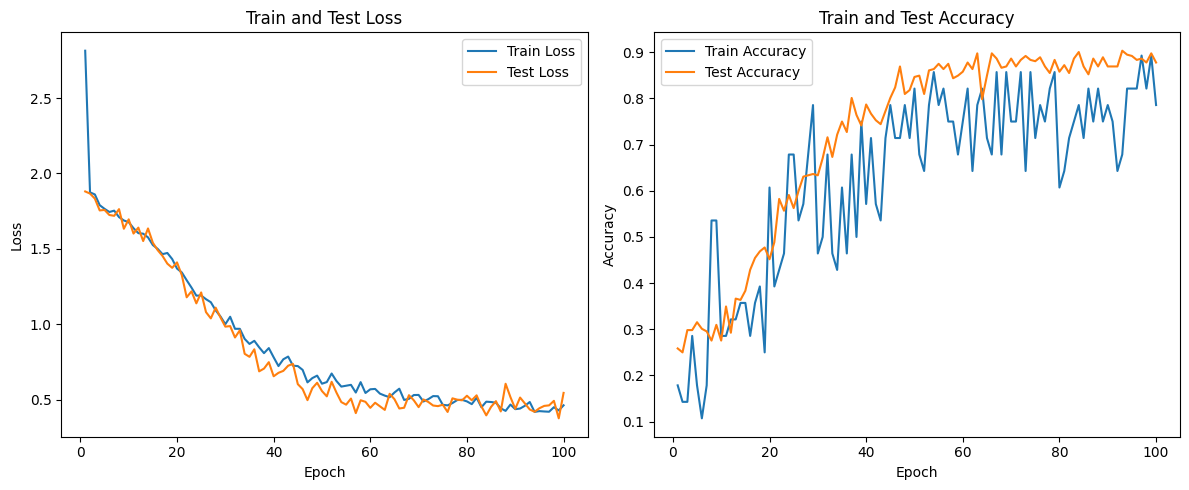

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

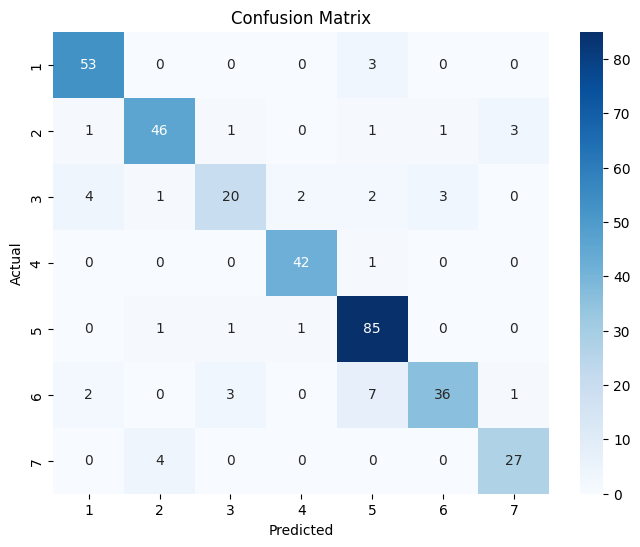

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.95      0.91        56
           2       0.88      0.87      0.88        53
           3       0.80      0.62      0.70        32
           4       0.93      0.98      0.95        43
           5       0.86      0.97      0.91        88
           6       0.90      0.73      0.81        49
           7       0.87      0.87      0.87        31

    accuracy                           0.88       352
   macro avg       0.88      0.86      0.86       352
weighted avg       0.88      0.88      0.87       352



## Resnet18 Evaluation

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds = train(
    resnet34_model, train_loader, test_loader, optimizer, criterion
)

100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [1/100]
Train Loss: 1.7810, Train Accuracy: 0.5000
Test Loss: 1.6583, Test Accuracy: 0.3608


100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch [2/100]
Train Loss: 1.5349, Train Accuracy: 0.3571
Test Loss: 2.0901, Test Accuracy: 0.2557


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [3/100]
Train Loss: 1.3661, Train Accuracy: 0.6071
Test Loss: 2.1266, Test Accuracy: 0.2926


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [4/100]
Train Loss: 1.1446, Train Accuracy: 0.5357
Test Loss: 2.4463, Test Accuracy: 0.3835


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [5/100]
Train Loss: 0.9516, Train Accuracy: 0.6429
Test Loss: 1.3033, Test Accuracy: 0.5085


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [6/100]
Train Loss: 0.7573, Train Accuracy: 0.6429
Test Loss: 2.9423, Test Accuracy: 0.4347


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [7/100]
Train Loss: 0.7102, Train Accuracy: 0.6071
Test Loss: 1.0081, Test Accuracy: 0.6989


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [8/100]
Train Loss: 0.4586, Train Accuracy: 0.8571
Test Loss: 0.4972, Test Accuracy: 0.8324


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [9/100]
Train Loss: 0.3726, Train Accuracy: 0.8571
Test Loss: 0.5506, Test Accuracy: 0.8239


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [10/100]
Train Loss: 0.3137, Train Accuracy: 0.8571
Test Loss: 0.4545, Test Accuracy: 0.8523


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [11/100]
Train Loss: 0.2647, Train Accuracy: 0.9286
Test Loss: 0.5814, Test Accuracy: 0.8239


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [12/100]
Train Loss: 0.1961, Train Accuracy: 0.9286
Test Loss: 0.4467, Test Accuracy: 0.8722


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [13/100]
Train Loss: 0.2060, Train Accuracy: 0.9286
Test Loss: 1.2536, Test Accuracy: 0.7159


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [14/100]
Train Loss: 0.1774, Train Accuracy: 1.0000
Test Loss: 0.3912, Test Accuracy: 0.9091


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [15/100]
Train Loss: 0.1328, Train Accuracy: 1.0000
Test Loss: 0.4730, Test Accuracy: 0.8807


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [16/100]
Train Loss: 0.1249, Train Accuracy: 0.9286
Test Loss: 0.1877, Test Accuracy: 0.9290


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [17/100]
Train Loss: 0.1169, Train Accuracy: 0.9643
Test Loss: 0.4325, Test Accuracy: 0.8778


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [18/100]
Train Loss: 0.1310, Train Accuracy: 0.8929
Test Loss: 0.3427, Test Accuracy: 0.9148


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [19/100]
Train Loss: 0.0964, Train Accuracy: 0.9643
Test Loss: 0.2367, Test Accuracy: 0.9290


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [20/100]
Train Loss: 0.0870, Train Accuracy: 0.9643
Test Loss: 0.2557, Test Accuracy: 0.9290


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [21/100]
Train Loss: 0.1186, Train Accuracy: 0.9643
Test Loss: 0.3044, Test Accuracy: 0.9062


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [22/100]
Train Loss: 0.0980, Train Accuracy: 0.8929
Test Loss: 0.4910, Test Accuracy: 0.8551


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [23/100]
Train Loss: 0.1133, Train Accuracy: 0.9643
Test Loss: 0.3457, Test Accuracy: 0.9148


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [24/100]
Train Loss: 0.1027, Train Accuracy: 1.0000
Test Loss: 0.3088, Test Accuracy: 0.9205


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [25/100]
Train Loss: 0.0621, Train Accuracy: 0.9643
Test Loss: 0.2231, Test Accuracy: 0.9403


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [26/100]
Train Loss: 0.0521, Train Accuracy: 0.9643
Test Loss: 0.2396, Test Accuracy: 0.9403


100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch [27/100]
Train Loss: 0.0317, Train Accuracy: 0.9643
Test Loss: 0.2076, Test Accuracy: 0.9517


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [28/100]
Train Loss: 0.0481, Train Accuracy: 1.0000
Test Loss: 0.2535, Test Accuracy: 0.9318


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [29/100]
Train Loss: 0.0557, Train Accuracy: 0.9643
Test Loss: 0.2729, Test Accuracy: 0.9261


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [30/100]
Train Loss: 0.0391, Train Accuracy: 1.0000
Test Loss: 0.2193, Test Accuracy: 0.9460


100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch [31/100]
Train Loss: 0.0288, Train Accuracy: 1.0000
Test Loss: 0.2406, Test Accuracy: 0.9403


100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch [32/100]
Train Loss: 0.0370, Train Accuracy: 0.9643
Test Loss: 0.4162, Test Accuracy: 0.8864


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [33/100]
Train Loss: 0.0542, Train Accuracy: 0.9643
Test Loss: 0.3350, Test Accuracy: 0.9233


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [34/100]
Train Loss: 0.0755, Train Accuracy: 0.9643
Test Loss: 0.3563, Test Accuracy: 0.8892


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [35/100]
Train Loss: 0.0759, Train Accuracy: 0.9286
Test Loss: 0.1368, Test Accuracy: 0.9432


100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch [36/100]
Train Loss: 0.0696, Train Accuracy: 0.9643
Test Loss: 0.2849, Test Accuracy: 0.9233


100%|██████████| 44/44 [00:32<00:00,  1.36it/s]


Epoch [37/100]
Train Loss: 0.0762, Train Accuracy: 0.9286
Test Loss: 0.2474, Test Accuracy: 0.9375


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [38/100]
Train Loss: 0.0946, Train Accuracy: 0.8929
Test Loss: 0.4221, Test Accuracy: 0.9006


100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch [39/100]
Train Loss: 0.0895, Train Accuracy: 0.9286
Test Loss: 0.2733, Test Accuracy: 0.9233


100%|██████████| 44/44 [00:31<00:00,  1.42it/s]


Epoch [40/100]
Train Loss: 0.0900, Train Accuracy: 0.9643
Test Loss: 0.4512, Test Accuracy: 0.9062


100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch [41/100]
Train Loss: 0.0680, Train Accuracy: 1.0000
Test Loss: 0.1548, Test Accuracy: 0.9460


100%|██████████| 44/44 [00:33<00:00,  1.32it/s]


Epoch [42/100]
Train Loss: 0.0400, Train Accuracy: 0.9643
Test Loss: 0.1665, Test Accuracy: 0.9631


100%|██████████| 44/44 [00:31<00:00,  1.38it/s]


Epoch [43/100]
Train Loss: 0.0216, Train Accuracy: 0.9286
Test Loss: 0.1622, Test Accuracy: 0.9659


100%|██████████| 44/44 [00:31<00:00,  1.39it/s]


Epoch [44/100]
Train Loss: 0.0357, Train Accuracy: 1.0000
Test Loss: 0.1962, Test Accuracy: 0.9574


100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch [45/100]
Train Loss: 0.0438, Train Accuracy: 1.0000
Test Loss: 0.2161, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch [46/100]
Train Loss: 0.0695, Train Accuracy: 0.8929
Test Loss: 0.3015, Test Accuracy: 0.9432


100%|██████████| 44/44 [00:31<00:00,  1.38it/s]


Epoch [47/100]
Train Loss: 0.0626, Train Accuracy: 0.9643
Test Loss: 0.1523, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch [48/100]
Train Loss: 0.0339, Train Accuracy: 0.9643
Test Loss: 0.1694, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch [49/100]
Train Loss: 0.0288, Train Accuracy: 1.0000
Test Loss: 0.1676, Test Accuracy: 0.9631


100%|██████████| 44/44 [00:31<00:00,  1.38it/s]


Epoch [50/100]
Train Loss: 0.0211, Train Accuracy: 1.0000
Test Loss: 0.1926, Test Accuracy: 0.9602


100%|██████████| 44/44 [00:31<00:00,  1.39it/s]


Epoch [51/100]
Train Loss: 0.0284, Train Accuracy: 1.0000
Test Loss: 0.2682, Test Accuracy: 0.9460


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [52/100]
Train Loss: 0.0480, Train Accuracy: 0.9643
Test Loss: 0.2449, Test Accuracy: 0.9432


100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch [53/100]
Train Loss: 0.0530, Train Accuracy: 1.0000
Test Loss: 0.3131, Test Accuracy: 0.9205


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [54/100]
Train Loss: 0.0609, Train Accuracy: 1.0000
Test Loss: 0.2825, Test Accuracy: 0.9347


100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch [55/100]
Train Loss: 0.0468, Train Accuracy: 1.0000
Test Loss: 0.1693, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch [56/100]
Train Loss: 0.0345, Train Accuracy: 1.0000
Test Loss: 0.1594, Test Accuracy: 0.9517


100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch [57/100]
Train Loss: 0.0175, Train Accuracy: 0.9643
Test Loss: 0.1549, Test Accuracy: 0.9602


100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch [58/100]
Train Loss: 0.0154, Train Accuracy: 1.0000
Test Loss: 0.1280, Test Accuracy: 0.9631


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [59/100]
Train Loss: 0.0144, Train Accuracy: 1.0000
Test Loss: 0.1467, Test Accuracy: 0.9659


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [60/100]
Train Loss: 0.0141, Train Accuracy: 1.0000
Test Loss: 0.1680, Test Accuracy: 0.9659


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [61/100]
Train Loss: 0.0308, Train Accuracy: 0.9643
Test Loss: 0.1490, Test Accuracy: 0.9716


100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch [62/100]
Train Loss: 0.0247, Train Accuracy: 0.9643
Test Loss: 0.1541, Test Accuracy: 0.9574


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [63/100]
Train Loss: 0.0184, Train Accuracy: 0.9286
Test Loss: 0.1499, Test Accuracy: 0.9631


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [64/100]
Train Loss: 0.0214, Train Accuracy: 1.0000
Test Loss: 0.2306, Test Accuracy: 0.9517


100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch [65/100]
Train Loss: 0.0435, Train Accuracy: 1.0000
Test Loss: 0.2354, Test Accuracy: 0.9375


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [66/100]
Train Loss: 0.0317, Train Accuracy: 1.0000
Test Loss: 0.1248, Test Accuracy: 0.9545


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [67/100]
Train Loss: 0.0339, Train Accuracy: 1.0000
Test Loss: 0.2023, Test Accuracy: 0.9574


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [68/100]
Train Loss: 0.0515, Train Accuracy: 0.9286
Test Loss: 0.5311, Test Accuracy: 0.8920


100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch [69/100]
Train Loss: 0.1049, Train Accuracy: 0.8929
Test Loss: 0.4801, Test Accuracy: 0.8807


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [70/100]
Train Loss: 0.0821, Train Accuracy: 1.0000
Test Loss: 0.3422, Test Accuracy: 0.9176


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [71/100]
Train Loss: 0.0469, Train Accuracy: 1.0000
Test Loss: 0.3067, Test Accuracy: 0.9403


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [72/100]
Train Loss: 0.0254, Train Accuracy: 1.0000
Test Loss: 0.2457, Test Accuracy: 0.9517


100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch [73/100]
Train Loss: 0.0312, Train Accuracy: 1.0000
Test Loss: 0.3635, Test Accuracy: 0.9261


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [74/100]
Train Loss: 0.0308, Train Accuracy: 0.9643
Test Loss: 0.2125, Test Accuracy: 0.9517


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [75/100]
Train Loss: 0.0542, Train Accuracy: 0.9643
Test Loss: 0.4040, Test Accuracy: 0.9290


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [76/100]
Train Loss: 0.0464, Train Accuracy: 0.9643
Test Loss: 0.4569, Test Accuracy: 0.9006


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [77/100]
Train Loss: 0.1005, Train Accuracy: 1.0000
Test Loss: 0.2267, Test Accuracy: 0.9460


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [78/100]
Train Loss: 0.0352, Train Accuracy: 1.0000
Test Loss: 0.2589, Test Accuracy: 0.9432


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [79/100]
Train Loss: 0.0287, Train Accuracy: 1.0000
Test Loss: 0.2210, Test Accuracy: 0.9631


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [80/100]
Train Loss: 0.0273, Train Accuracy: 1.0000
Test Loss: 0.2042, Test Accuracy: 0.9517


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [81/100]
Train Loss: 0.0401, Train Accuracy: 0.9643
Test Loss: 0.2103, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch [82/100]
Train Loss: 0.0315, Train Accuracy: 0.9643
Test Loss: 0.1936, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [83/100]
Train Loss: 0.0184, Train Accuracy: 1.0000
Test Loss: 0.1714, Test Accuracy: 0.9545


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [84/100]
Train Loss: 0.0190, Train Accuracy: 0.9643
Test Loss: 0.2260, Test Accuracy: 0.9545


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [85/100]
Train Loss: 0.0235, Train Accuracy: 0.9643
Test Loss: 0.2008, Test Accuracy: 0.9574


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [86/100]
Train Loss: 0.0212, Train Accuracy: 0.9643
Test Loss: 0.2016, Test Accuracy: 0.9602


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [87/100]
Train Loss: 0.0395, Train Accuracy: 0.9286
Test Loss: 0.3017, Test Accuracy: 0.9460


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [88/100]
Train Loss: 0.0327, Train Accuracy: 1.0000
Test Loss: 0.3643, Test Accuracy: 0.9233


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [89/100]
Train Loss: 0.0561, Train Accuracy: 1.0000
Test Loss: 0.3817, Test Accuracy: 0.9119


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [90/100]
Train Loss: 0.0635, Train Accuracy: 1.0000
Test Loss: 0.2232, Test Accuracy: 0.9545


100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch [91/100]
Train Loss: 0.0563, Train Accuracy: 0.9286
Test Loss: 0.3182, Test Accuracy: 0.9290


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [92/100]
Train Loss: 0.0438, Train Accuracy: 1.0000
Test Loss: 0.2580, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [93/100]
Train Loss: 0.0293, Train Accuracy: 1.0000
Test Loss: 0.2304, Test Accuracy: 0.9375


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [94/100]
Train Loss: 0.0362, Train Accuracy: 1.0000
Test Loss: 0.1920, Test Accuracy: 0.9631


100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch [95/100]
Train Loss: 0.0374, Train Accuracy: 1.0000
Test Loss: 0.3077, Test Accuracy: 0.9545


100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch [96/100]
Train Loss: 0.0327, Train Accuracy: 0.9643
Test Loss: 0.3470, Test Accuracy: 0.9489


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [97/100]
Train Loss: 0.0453, Train Accuracy: 1.0000
Test Loss: 0.3540, Test Accuracy: 0.9432


100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch [98/100]
Train Loss: 0.0556, Train Accuracy: 0.9643
Test Loss: 0.2563, Test Accuracy: 0.9403


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [99/100]
Train Loss: 0.0597, Train Accuracy: 0.9643
Test Loss: 0.2944, Test Accuracy: 0.9460


100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch [100/100]
Train Loss: 0.0478, Train Accuracy: 0.9643
Test Loss: 0.2437, Test Accuracy: 0.9489


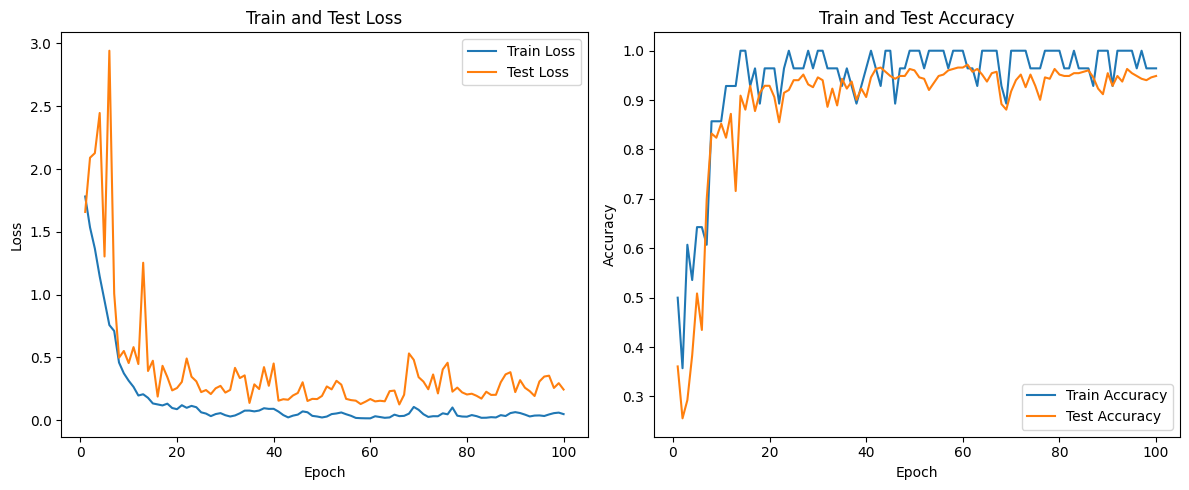

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

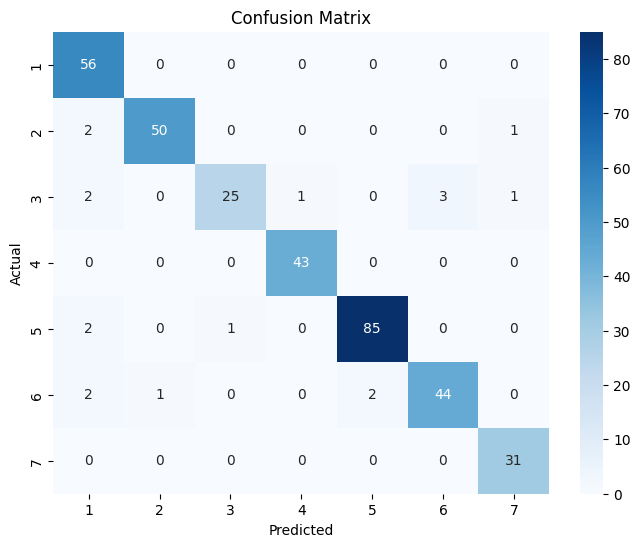

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

           1       0.88      1.00      0.93        56
           2       0.98      0.94      0.96        53
           3       0.96      0.78      0.86        32
           4       0.98      1.00      0.99        43
           5       0.98      0.97      0.97        88
           6       0.94      0.90      0.92        49
           7       0.94      1.00      0.97        31

    accuracy                           0.95       352
   macro avg       0.95      0.94      0.94       352
weighted avg       0.95      0.95      0.95       352



## Model Predictions

In [ ]:
import io
from google.colab import files


# Upload file gambar
uploaded = files.upload()


# Transformasi
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std= [0.225])
])

# Load gambar yang diupload
for fn in uploaded.keys():
    if fn.lower().endswith(('.png', '.jpg', '.jpeg')):
      image = Image.open(io.BytesIO(uploaded[fn]))
      transformed_image = transform(image)
      transformed_image = transformed_image.unsqueeze(0)

      # Lakukan prediksi menggunakan model
      model.eval()
      with torch.no_grad():
          model.to(device)
          transformed_image = transformed_image.to(device)
          output = model(transformed_image)
          predicted_class = output.argmax(dim=1).item()
          predicted_class_name = classes[predicted_class]

      print(f'Predicted class for uploaded image "{fn}" is: {predicted_class_name}')

    else :
      print(f'File "{fn}" is not an image file.')

Saving test_2.jpeg to test_2.jpeg
Predicted class for uploaded image "test_2.jpeg" is: 5


## Save Model

In [ ]:
import pickle

# Simpan model ke file
with open('/content/drive/MyDrive/CapsNet Image Classification/cnn_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
# Simpan model ke file
with open('/content/drive/MyDrive/CapsNet Image Classification/resnet34_model.pkl', 'wb') as model_file:
    pickle.dump(resnet34_model, model_file)